In [494]:
import numpy as np
import math
import matplotlib.pyplot as plt

def score(x):
    n = len(x)
    if n % 2 == 0:
        mid = n/2
        return np.concatenate((np.arange(1, mid+1, 1), list(reversed(np.arange(1, mid+1, 1)))), axis=None)[:-1]
    mid = n//2
    return np.concatenate((np.arange(1, mid+2, 1), list(reversed(np.arange(1, mid+1, 1)))), axis=None)[:-1]

def dp_exponential_median(x, epsilon=0.15):
    GSs = 1.
    x = np.concatenate((x, 1), axis=None)
    x = np.concatenate((x, -1), axis=None)
    x = np.sort(x)
    score_arr = score(x)
    
    bins_width = np.diff(x)
    probabilities = bins_width * np.exp(epsilon * score_arr / (2 * GSs))
    probabilities /= np.sum(probabilities)
    bin_choice = np.random.choice(np.arange(0, len(bins_width)), p=probabilities)
    return np.random.uniform(x[bin_choice], x[bin_choice+1])

In [495]:
def clamp(x, bounds):
    """Replace any x_i less than lower with lower, 
           and any x_i greater than upper with upper."""
    return np.clip(x, *bounds)

def generate_data(sigma, n=200):
    x = np.random.normal(0.5, sigma, size=n)
    x = clamp(x, (-1, 1))
    return x

In [496]:
import math

def RMSE(answers, exact_vals):
    diff = exact_vals - answers
    total = sum(diff**2)
    return math.sqrt(total/len(answers))

In [497]:
num_trials = 10000

def run_trial(sigma):
    dp_medians = np.zeros(num_trials)
    real_medians = np.zeros(num_trials)
    for i in range(num_trials):
        x = generate_data(sigma)
        dp_medians[i] = dp_exponential_median(x)
        real_medians[i] = np.median(x)

    res = RMSE(dp_medians, real_medians)
    return res

0.1
0.10816326530612246
0.1163265306122449
0.12448979591836735
0.1326530612244898
0.14081632653061227
0.1489795918367347
0.15714285714285714
0.1653061224489796
0.17346938775510207
0.1816326530612245
0.18979591836734694
0.1979591836734694
0.20612244897959187
0.2142857142857143
0.22244897959183674
0.2306122448979592
0.23877551020408164
0.2469387755102041
0.2551020408163266
0.263265306122449
0.27142857142857146
0.2795918367346939
0.28775510204081634
0.29591836734693877
0.3040816326530612
0.3122448979591837
0.3204081632653062
0.3285714285714286
0.33673469387755106
0.3448979591836735
0.35306122448979593
0.36122448979591837
0.3693877551020408
0.37755102040816324
0.3857142857142858
0.3938775510204082
0.40204081632653066
0.4102040816326531
0.41836734693877553
0.42653061224489797
0.4346938775510204
0.44285714285714284
0.4510204081632654
0.4591836734693878
0.46734693877551026
0.4755102040816327
0.48367346938775513
0.49183673469387756
0.5


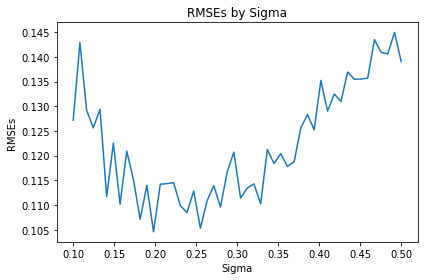

In [498]:
import matplotlib.pyplot as plt

x_vals = np.linspace(0.1, 0.5, 50)
y_vals = np.zeros(len(x_vals))

for i, sigma in enumerate(x_vals):
    y_vals[i] = run_trial(sigma)
    print(sigma)

plt.plot(x_vals, y_vals)

plt.title("RMSEs by Sigma")
plt.xlabel("Sigma")
plt.ylabel("RMSEs")
plt.tight_layout()
plt.savefig('hw5_plot_a.png')
plt.show()

In [422]:
def dp_synthetic_data(data, b, epsilon, k, m):
    # bins into k by k
    data = data.T
    x = data[0]
    y = data[1]
    sensitive_hist, xbins, ybins = np.histogram2d(x=x, y=y, bins=(k, k))
    
    # makes histogram epsilon-dp
    sensitivity = 2
    scale = sensitivity / epsilon
    noise = np.random.laplace(loc=0, scale=scale, size=sensitive_hist.shape)
    
    dp_hist = sensitive_hist + noise
    dp_hist_clean = clamp(dp_hist, (0, math.inf))
    
    dp_hist_clean = np.round(dp_hist_clean)
    
    # create synthetic data from noisy histograms
    synthetic_data = np.zeros((m, 2))
    probabilities = dp_hist_clean.flatten()
    probabilities /= sum(probabilities)
    for row in range(m):
        bin_choice = np.random.choice(np.arange(0, k**2), p=probabilities)
        i = bin_choice // k
        j = bin_choice % k - 1 # to get it to be 0-indexed
        if j == -1:
            j = k-1
        x = np.random.uniform(xbins[i], xbins[i+1], 1)
        y = np.random.uniform(ybins[j], ybins[j+1], 1)
        synthetic_data[row][0] = x
        synthetic_data[row][1] = y
    return synthetic_data

In [459]:
def generate_data(n):
    x_s = np.random.uniform(-0.5,0.5,n)
    noise = np.random.normal(0, np.sqrt(0.02), size=n)
    y_s = x_s + noise
    y_s = clamp(y_s, (-1, 1))
    res = np.vstack((x_s, y_s)).T
    return res

def calculate_ols(data):
    data = data.T
    Sxy = np.dot(data[0], data[1])
    Sxx = np.dot(data[0], data[0])
    return Sxy / Sxx

In [424]:
def bias(betas):
    return np.mean(betas) - 1
    
def std_dev(betas):
    return np.std(betas)

In [425]:
epsilon = 0.1
b = 1
k = 20
num_trials = 100

# 1) ols bias on real, 2) ols bias on synthetic, 3) ols std dev on real, 4) ols std dev on synthetic

def run_trial(n):
    real_vals = np.zeros(num_trials)
    synthetic_vals = np.zeros(num_trials)
    for i in range(num_trials):
        data = generate_data(n)
        real_vals[i] = calculate_ols(data)
        
        synthetic_data = dp_synthetic_data(data, b, epsilon, k, n)
        synthetic_vals[i] = calculate_ols(synthetic_data)

    return bias(real_vals), bias(synthetic_vals), std_dev(real_vals), std_dev(synthetic_vals)

100%|███████████████████████████████████████████| 50/50 [06:47<00:00,  8.14s/it]


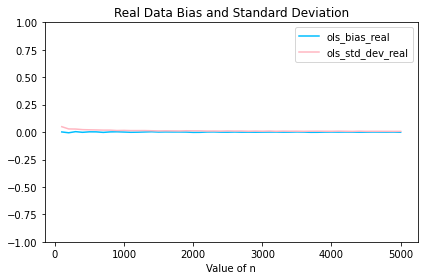

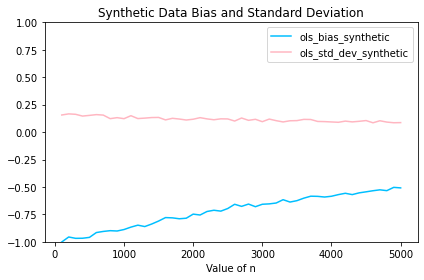

In [431]:
import matplotlib.pyplot as plt
from tqdm import tqdm

ols_bias_real = np.zeros(50)
ols_bias_synthetic = np.zeros(50)
ols_std_dev_real = np.zeros(50)
ols_std_dev_synthetic = np.zeros(50)

i = 0
for n in tqdm(range(100, 5001, 100)):
    a, b, c, d = run_trial(n)
    ols_bias_real[i] = a
    ols_bias_synthetic[i] = b
    ols_std_dev_real[i] = c
    ols_std_dev_synthetic[i] = d
    i += 1

plt.plot(range(100, 5001, 100), ols_bias_real, color='deepskyblue', label="ols_bias_real")
plt.plot(range(100, 5001, 100), ols_std_dev_real, color='lightpink', label="ols_std_dev_real")
plt.ylim([-1, 1])

plt.title("Real Data Bias and Standard Deviation")
plt.xlabel("Value of n")
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig('hw5_plot_ols.png')
plt.show()

plt.plot(range(100, 5001, 100), ols_bias_synthetic, color='deepskyblue', label="ols_bias_synthetic")
plt.plot(range(100, 5001, 100), ols_std_dev_synthetic, color='lightpink', label="ols_std_dev_synthetic")
plt.ylim([-1, 1])

plt.title("Synthetic Data Bias and Standard Deviation")
plt.xlabel("Value of n")
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig('hw5_plot_dp.png')
plt.show()

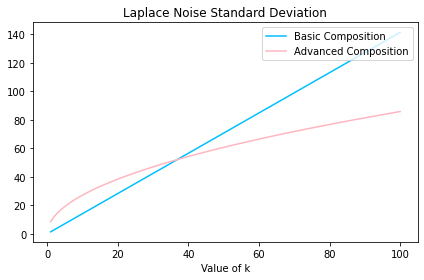

In [481]:
epsilon = 1
delta = 10e-9
sensitivity = 1

upperbound_k = 100
basic_ys = np.zeros(upperbound_k)
advanced_ys = np.zeros(upperbound_k)
x_s = range(1, upperbound_k + 1)

for k in x_s:
    basic_e0 = epsilon/k
    basic_ys[k-1] = np.sqrt(2) * sensitivity/basic_e0 # from formula for variance of laplace given in lec slides
    
    advanced_e0 = epsilon/np.sqrt(2*k*np.log(1/delta))
    advanced_ys[k-1] = np.sqrt(2) * sensitivity/advanced_e0 # from formula for variance of laplace given in lec slides

plt.plot(x_s, basic_ys, color='deepskyblue', label="Basic Composition")
plt.plot(x_s, advanced_ys, color='lightpink', label="Advanced Composition")

plt.title("Laplace Noise Standard Deviation")
plt.xlabel("Value of k")
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig('hw5_laplace_noise.png')
plt.show()

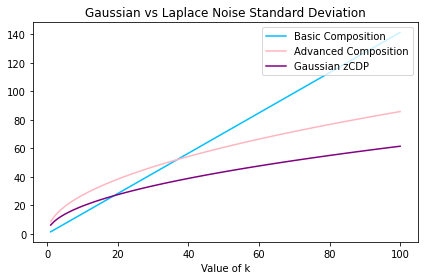

In [499]:
rho = epsilon - 2*np.log(delta) - 2 * np.sqrt(np.log(delta)*(-epsilon + np.log(delta))) # from property 3 given in pset (solved for rho)

upperbound_k = 100
gaussian_ys = np.zeros(upperbound_k)
x_s = range(1, upperbound_k + 1)

for k in x_s:
    comp_rho = rho/k # from property 2 given in the pset
    gaussian_ys[k-1] = np.sqrt(sensitivity**2/(2*comp_rho)) # from property 1 given in the pset

plt.plot(x_s, basic_ys, color='deepskyblue', label="Basic Composition")
plt.plot(x_s, advanced_ys, color='lightpink', label="Advanced Composition")
plt.plot(x_s, gaussian_ys, color='purple', label="Gaussian zCDP")

plt.title("Gaussian vs Laplace Noise Standard Deviation")
plt.xlabel("Value of k")
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig('hw5_gaussian_noise.png')
plt.show()